**make_circles**

This a non-linearity classification problem from Scikit Learn [data sets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)

## 1. Get the data

In [1]:
# Make device agnostic code
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
X[:10], y[:10]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872],
        [ 0.77151327,  0.14775959],
        [-0.16932234, -0.79345575],
        [-0.1214858 ,  1.02150905]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

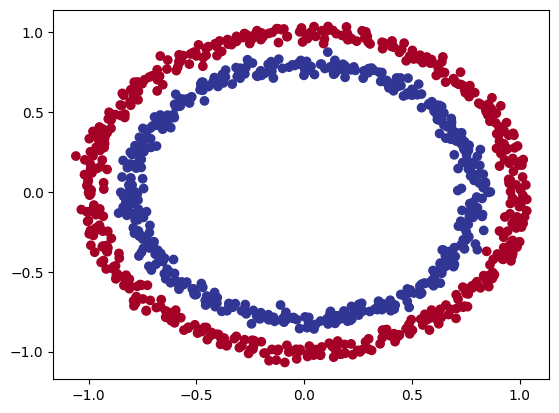

In [3]:
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdYlBu)

In [4]:
# Convert data to tensors and then to train and test splits
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [7]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [8]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [18]:
X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [19]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 2. Build a model

In [13]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 20)
    self.layer_2 = nn.Linear(in_features = 20, out_features = 30)
    self.layer_3 = nn.Linear(in_features = 30, out_features = 10)
    self.layer_4 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

In [14]:
model = CircleModel()
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr = 0.1)

In [17]:
# Let's visualize the parameters
list(model.parameters())

[Parameter containing:
 tensor([[-0.5490, -0.1075],
         [-0.4753, -0.0676],
         [-0.0699,  0.6799],
         [ 0.3149,  0.0574],
         [ 0.5286,  0.3965],
         [ 0.5702, -0.0322],
         [-0.2931, -0.6619],
         [ 0.1362,  0.7011],
         [-0.5275,  0.3427],
         [-0.4434, -0.0845],
         [-0.4856,  0.2202],
         [-0.2995,  0.2439],
         [-0.0512, -0.5517],
         [-0.5685, -0.2079],
         [-0.5212,  0.4594],
         [-0.6685, -0.1301],
         [-0.3676, -0.5469],
         [ 0.0741,  0.2345],
         [ 0.5251,  0.3693],
         [ 0.5530,  0.1183]], requires_grad=True),
 Parameter containing:
 tensor([-0.1124,  0.4600, -0.6859,  0.2063, -0.3299, -0.0354, -0.5699, -0.1759,
          0.0334, -0.3962,  0.2512, -0.0981,  0.0257,  0.6280,  0.1117, -0.5624,
          0.3847, -0.2885,  0.5521, -0.1970], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1559,  0.0207,  0.0036, -0.2170,  0.2215, -0.0910,  0.1714,  0.1295,
          -0.0186,

## 3. Train the model

In [20]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad (we do zero the gradients from the optimizer)
  optimizer.zero_grad()

  # 4. Loss backwards (backpropagation)
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
  # Print out what is happening
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.6947, Acc: 50.00 | Test Loss: 0.6958, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6928, Acc: 50.88 | Test Loss: 0.6943, Test Acc: 47.50%
Epoch: 200 | Loss: 0.6922, Acc: 51.75 | Test Loss: 0.6939, Test Acc: 47.00%
Epoch: 300 | Loss: 0.6914, Acc: 52.50 | Test Loss: 0.6935, Test Acc: 47.00%
Epoch: 400 | Loss: 0.6903, Acc: 53.37 | Test Loss: 0.6930, Test Acc: 47.00%
Epoch: 500 | Loss: 0.6886, Acc: 53.50 | Test Loss: 0.6922, Test Acc: 48.50%
Epoch: 600 | Loss: 0.6859, Acc: 54.00 | Test Loss: 0.6907, Test Acc: 49.00%
Epoch: 700 | Loss: 0.6806, Acc: 56.00 | Test Loss: 0.6872, Test Acc: 49.50%
Epoch: 800 | Loss: 0.6691, Acc: 62.62 | Test Loss: 0.6786, Test Acc: 56.00%
Epoch: 900 | Loss: 0.6379, Acc: 71.00 | Test Loss: 0.6520, Test Acc: 66.50%


## 5. Evaluating the model

In [21]:
# Makes predictions
model.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [22]:
import requests
from pathlib import Path

# Download helper function from Learn Pytorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Download helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/af6548e52663c8395fe2777bd0fbfd6ac85fd6f8/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

Download helper_functions.py


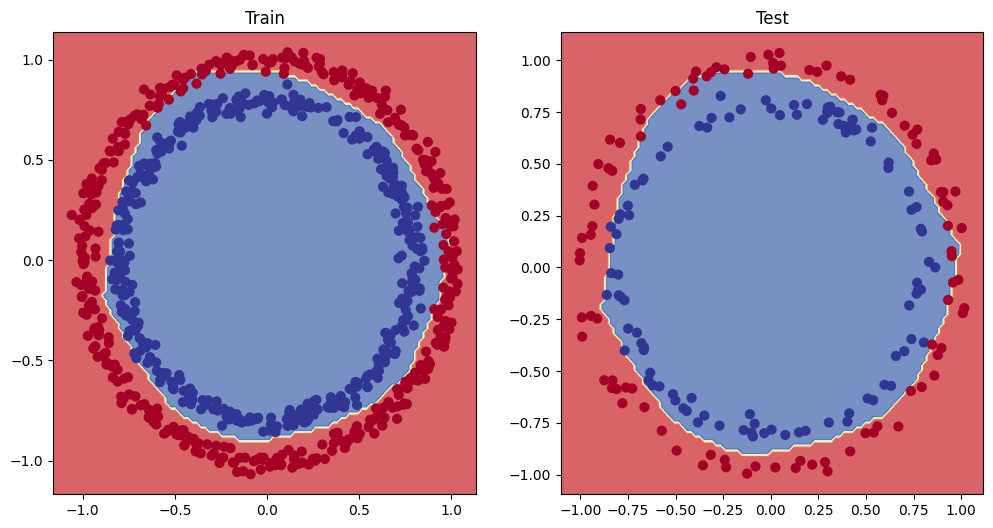

In [27]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boudaries
plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)